# 🎓 Week 9 - Day 2: Advanced Optimizers

## Today's Goals:
✅ Implement different optimizers (SGD, SGD+Momentum, AdaGrad, RMSProp, Adam)
✅ Compare their performance on MNIST dataset
✅ Visualize training curves and convergence speed
✅ Understand why Adam is the industry standard

---

## 📦 Part 1: Setup and Imports

Let's import all necessary libraries and set up our environment.

In [1]:
# Core libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

Matplotlib is building the font cache; this may take a moment.


✅ Libraries imported successfully!
NumPy version: 2.3.4


## 📊 Part 2: Load and Prepare MNIST Dataset

MNIST contains 70,000 handwritten digit images (0-9). Perfect for comparing optimizers!

In [2]:
print("📥 Loading MNIST dataset...")

# Load MNIST data (this might take a moment first time)
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X, y = mnist['data'].values, mnist['target'].values.astype(int)

print(f"✅ Dataset loaded!")
print(f"   Total samples: {X.shape[0]:,}")
print(f"   Features per sample: {X.shape[1]} (28x28 pixels)")
print(f"   Classes: {len(np.unique(y))} (digits 0-9)")

📥 Loading MNIST dataset...
✅ Dataset loaded!
   Total samples: 70,000
   Features per sample: 784 (28x28 pixels)
   Classes: 10 (digits 0-9)


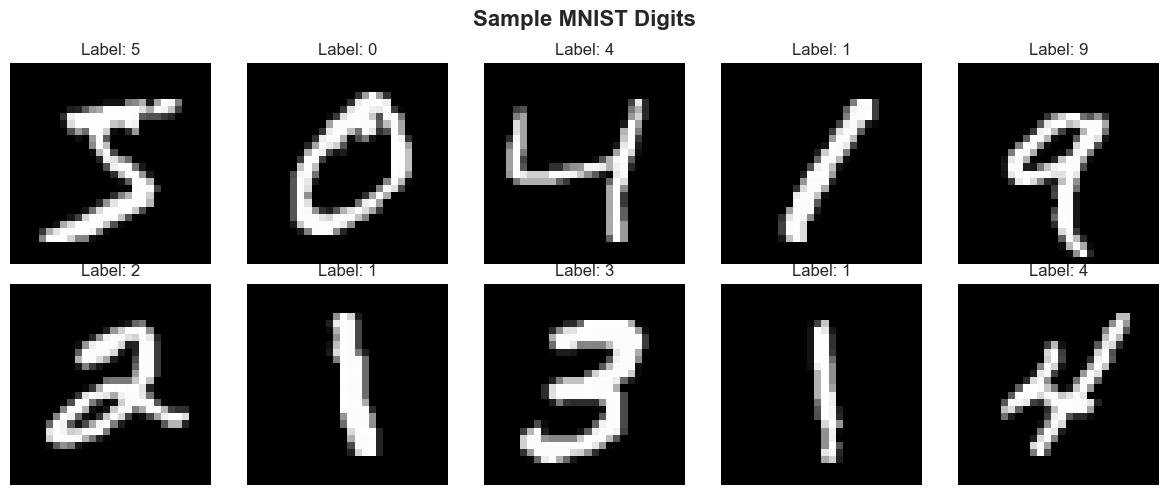

📸 These are the handwritten digits we'll classify!


In [3]:
# Visualize some samples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Sample MNIST Digits', fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'Label: {y[i]}', fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

print("📸 These are the handwritten digits we'll classify!")

## 🔧 Part 3: Preprocess Data

We'll normalize the data and create train/test splits.

In [4]:
# Normalize to [0, 1] range
X = X / 255.0

# Use smaller subset for faster training (10,000 samples)
X_small = X[:10000]
y_small = y[:10000]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small, test_size=0.2, random_state=42, stratify=y_small
)

print("✅ Data preprocessed!")
print(f"   Training samples: {X_train.shape[0]:,}")
print(f"   Test samples: {X_test.shape[0]:,}")
print(f"   Pixel values normalized to: [{X_train.min():.2f}, {X_train.max():.2f}]")

✅ Data preprocessed!
   Training samples: 8,000
   Test samples: 2,000
   Pixel values normalized to: [0.00, 1.00]


In [5]:
# One-hot encode labels for multi-class classification
def one_hot_encode(y, num_classes=10):
    n = y.shape[0]
    one_hot = np.zeros((n, num_classes))
    one_hot[np.arange(n), y] = 1
    return one_hot

y_train_encoded = one_hot_encode(y_train)
y_test_encoded = one_hot_encode(y_test)

print("✅ Labels one-hot encoded!")
print(f"   Original label shape: {y_train.shape}")
print(f"   Encoded label shape: {y_train_encoded.shape}")
print(f"   Example: Label {y_train[0]} → {y_train_encoded[0]}")

✅ Labels one-hot encoded!
   Original label shape: (8000,)
   Encoded label shape: (8000, 10)
   Example: Label 0 → [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## 🧠 Part 4: Build a Simple Neural Network

We'll create a 2-layer neural network to compare optimizers.

In [6]:
class SimpleNN:
    def __init__(self, input_size=784, hidden_size=128, output_size=10):
        # Initialize weights with He initialization
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2/input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2/hidden_size)
        self.b2 = np.zeros((1, output_size))
        
    def relu(self, Z):
        return np.maximum(0, Z)
    
    def relu_derivative(self, Z):
        return (Z > 0).astype(float)
    
    def softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)
    
    def forward(self, X):
        # Hidden layer
        self.Z1 = X.dot(self.W1) + self.b1
        self.A1 = self.relu(self.Z1)
        
        # Output layer
        self.Z2 = self.A1.dot(self.W2) + self.b2
        self.A2 = self.softmax(self.Z2)
        
        return self.A2
    
    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        log_likelihood = -np.log(y_pred[range(m), y_true.argmax(axis=1)] + 1e-8)
        loss = np.sum(log_likelihood) / m
        return loss
    
    def backward(self, X, y_true):
        m = X.shape[0]
        
        # Output layer gradients
        dZ2 = self.A2 - y_true
        dW2 = self.A1.T.dot(dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m
        
        # Hidden layer gradients
        dA1 = dZ2.dot(self.W2.T)
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        dW1 = X.T.dot(dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m
        
        return {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}
    
    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)
    
    def accuracy(self, X, y):
        predictions = self.predict(X)
        y_labels = y if y.ndim == 1 else np.argmax(y, axis=1)
        return np.mean(predictions == y_labels)

print("✅ Neural Network class defined!")
print("   Architecture: 784 → 128 → 10")
print("   Activation: ReLU (hidden) + Softmax (output)")

✅ Neural Network class defined!
   Architecture: 784 → 128 → 10
   Activation: ReLU (hidden) + Softmax (output)


## ⚙️ Part 5: Implement Different Optimizers

Now let's implement all the optimizers we learned about!

In [7]:
class SGDOptimizer:
    """Standard SGD without momentum"""
    def __init__(self, learning_rate=0.01):
        self.lr = learning_rate
        self.name = "SGD"
    
    def update(self, model, grads):
        model.W1 -= self.lr * grads['dW1']
        model.b1 -= self.lr * grads['db1']
        model.W2 -= self.lr * grads['dW2']
        model.b2 -= self.lr * grads['db2']

class SGDMomentumOptimizer:
    """SGD with Momentum"""
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.lr = learning_rate
        self.momentum = momentum
        self.name = f"SGD+Momentum(β={momentum})"
        self.v = None
    
    def update(self, model, grads):
        if self.v is None:
            self.v = {k: np.zeros_like(v) for k, v in grads.items()}
        
        for key in grads:
            self.v[key] = self.momentum * self.v[key] + (1 - self.momentum) * grads[key]
        
        model.W1 -= self.lr * self.v['dW1']
        model.b1 -= self.lr * self.v['db1']
        model.W2 -= self.lr * self.v['dW2']
        model.b2 -= self.lr * self.v['db2']

class AdaGradOptimizer:
    """AdaGrad - Adaptive Gradient"""
    def __init__(self, learning_rate=0.01, epsilon=1e-8):
        self.lr = learning_rate
        self.epsilon = epsilon
        self.name = "AdaGrad"
        self.G = None
    
    def update(self, model, grads):
        if self.G is None:
            self.G = {k: np.zeros_like(v) for k, v in grads.items()}
        
        for key in grads:
            self.G[key] += grads[key] ** 2
        
        model.W1 -= (self.lr / (np.sqrt(self.G['dW1']) + self.epsilon)) * grads['dW1']
        model.b1 -= (self.lr / (np.sqrt(self.G['db1']) + self.epsilon)) * grads['db1']
        model.W2 -= (self.lr / (np.sqrt(self.G['dW2']) + self.epsilon)) * grads['dW2']
        model.b2 -= (self.lr / (np.sqrt(self.G['db2']) + self.epsilon)) * grads['db2']

class RMSPropOptimizer:
    """RMSProp - Root Mean Square Propagation"""
    def __init__(self, learning_rate=0.001, decay_rate=0.9, epsilon=1e-8):
        self.lr = learning_rate
        self.decay_rate = decay_rate
        self.epsilon = epsilon
        self.name = f"RMSProp(β={decay_rate})"
        self.cache = None
    
    def update(self, model, grads):
        if self.cache is None:
            self.cache = {k: np.zeros_like(v) for k, v in grads.items()}
        
        for key in grads:
            self.cache[key] = self.decay_rate * self.cache[key] + (1 - self.decay_rate) * (grads[key] ** 2)
        
        model.W1 -= (self.lr / (np.sqrt(self.cache['dW1']) + self.epsilon)) * grads['dW1']
        model.b1 -= (self.lr / (np.sqrt(self.cache['db1']) + self.epsilon)) * grads['db1']
        model.W2 -= (self.lr / (np.sqrt(self.cache['dW2']) + self.epsilon)) * grads['dW2']
        model.b2 -= (self.lr / (np.sqrt(self.cache['db2']) + self.epsilon)) * grads['db2']

class AdamOptimizer:
    """Adam - Adaptive Moment Estimation"""
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.name = f"Adam(α={learning_rate})"
        self.m = None
        self.v = None
        self.t = 0
    
    def update(self, model, grads):
        if self.m is None:
            self.m = {k: np.zeros_like(v) for k, v in grads.items()}
            self.v = {k: np.zeros_like(v) for k, v in grads.items()}
        
        self.t += 1
        
        for key in grads:
            # Update biased first and second moments
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key]
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[key] ** 2)
            
            # Bias correction
            m_corrected = self.m[key] / (1 - self.beta1 ** self.t)
            v_corrected = self.v[key] / (1 - self.beta2 ** self.t)
            
            # Update parameters
            if key == 'dW1':
                model.W1 -= self.lr * m_corrected / (np.sqrt(v_corrected) + self.epsilon)
            elif key == 'db1':
                model.b1 -= self.lr * m_corrected / (np.sqrt(v_corrected) + self.epsilon)
            elif key == 'dW2':
                model.W2 -= self.lr * m_corrected / (np.sqrt(v_corrected) + self.epsilon)
            elif key == 'db2':
                model.b2 -= self.lr * m_corrected / (np.sqrt(v_corrected) + self.epsilon)

print("✅ All optimizers implemented!")
print("   1. SGD")
print("   2. SGD + Momentum")
print("   3. AdaGrad")
print("   4. RMSProp")
print("   5. Adam")

✅ All optimizers implemented!
   1. SGD
   2. SGD + Momentum
   3. AdaGrad
   4. RMSProp
   5. Adam


## 🏋️ Part 6: Training Function

Let's create a training function that works with any optimizer.

In [8]:
def train_model(model, optimizer, X_train, y_train, X_test, y_test, epochs=50, batch_size=128, verbose=True):
    """Train a model with a given optimizer"""
    history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}
    n_samples = X_train.shape[0]
    n_batches = n_samples // batch_size
    
    start_time = time.time()
    
    for epoch in range(epochs):
        # Shuffle data
        indices = np.random.permutation(n_samples)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]
        
        epoch_loss = 0
        
        # Mini-batch training
        for batch in range(n_batches):
            start_idx = batch * batch_size
            end_idx = start_idx + batch_size
            
            X_batch = X_train_shuffled[start_idx:end_idx]
            y_batch = y_train_shuffled[start_idx:end_idx]
            
            # Forward pass
            y_pred = model.forward(X_batch)
            batch_loss = model.compute_loss(y_batch, y_pred)
            epoch_loss += batch_loss
            
            # Backward pass
            grads = model.backward(X_batch, y_batch)
            
            # Update weights
            optimizer.update(model, grads)
        
        # Calculate metrics
        train_loss = epoch_loss / n_batches
        test_pred = model.forward(X_test)
        test_loss = model.compute_loss(y_test, test_pred)
        train_acc = model.accuracy(X_train, y_train)
        test_acc = model.accuracy(X_test, y_test)
        
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        
        if verbose and (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f} - Acc: {train_acc:.4f} - Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.4f}")
    
    elapsed_time = time.time() - start_time
    
    if verbose:
        print(f"\n✅ Training completed in {elapsed_time:.2f} seconds!")
        print(f"   Final Test Accuracy: {test_acc:.4f}")
    
    return history, elapsed_time

print("✅ Training function ready!")

✅ Training function ready!


## 🚀 Part 7: Train with All Optimizers

Now let's train separate models with each optimizer and compare!

In [9]:
# Define all optimizers
optimizers = [
    SGDOptimizer(learning_rate=0.1),
    SGDMomentumOptimizer(learning_rate=0.1, momentum=0.9),
    AdaGradOptimizer(learning_rate=0.01),
    RMSPropOptimizer(learning_rate=0.001, decay_rate=0.9),
    AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999)
]

# Store results
results = {}

print("🏋️ Training models with different optimizers...\n")
print("=" * 70)

for optimizer in optimizers:
    print(f"\n🔄 Training with {optimizer.name}...")
    print("-" * 70)
    
    # Create fresh model
    model = SimpleNN()
    
    # Train
    history, elapsed = train_model(
        model, optimizer, X_train, y_train_encoded, X_test, y_test_encoded,
        epochs=50, batch_size=128, verbose=True
    )
    
    results[optimizer.name] = {
        'history': history,
        'time': elapsed,
        'final_acc': history['test_acc'][-1]
    }
    
    print("=" * 70)

print("\n🎉 All models trained!")

🏋️ Training models with different optimizers...


🔄 Training with SGD...
----------------------------------------------------------------------
Epoch 10/50 - Loss: 0.2279 - Acc: 0.9413 - Test Loss: 0.2850 - Test Acc: 0.9215
Epoch 20/50 - Loss: 0.1476 - Acc: 0.9647 - Test Loss: 0.2309 - Test Acc: 0.9355
Epoch 30/50 - Loss: 0.1004 - Acc: 0.9788 - Test Loss: 0.2083 - Test Acc: 0.9405
Epoch 40/50 - Loss: 0.0696 - Acc: 0.9868 - Test Loss: 0.1998 - Test Acc: 0.9430
Epoch 50/50 - Loss: 0.0506 - Acc: 0.9924 - Test Loss: 0.1972 - Test Acc: 0.9410

✅ Training completed in 8.04 seconds!
   Final Test Accuracy: 0.9410

🔄 Training with SGD+Momentum(β=0.9)...
----------------------------------------------------------------------
Epoch 10/50 - Loss: 0.2257 - Acc: 0.9427 - Test Loss: 0.2753 - Test Acc: 0.9205
Epoch 20/50 - Loss: 0.1507 - Acc: 0.9625 - Test Loss: 0.2307 - Test Acc: 0.9345
Epoch 30/50 - Loss: 0.1047 - Acc: 0.9762 - Test Loss: 0.2148 - Test Acc: 0.9380
Epoch 40/50 - Loss: 0.0749 - Acc: 0

## 📈 Part 8: Compare Results

Let's visualize the training curves and see which optimizer performs best!

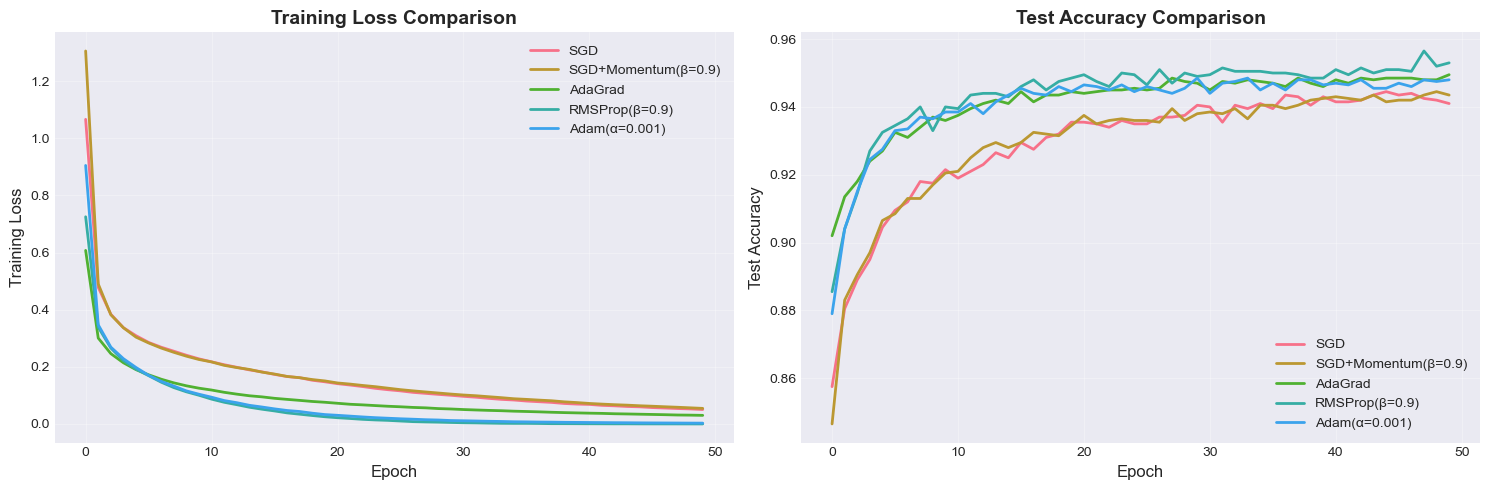

📊 Training curves plotted!


In [10]:
# Plot training loss curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training Loss
ax = axes[0]
for name, result in results.items():
    ax.plot(result['history']['train_loss'], label=name, linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Training Loss', fontsize=12)
ax.set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Test Accuracy
ax = axes[1]
for name, result in results.items():
    ax.plot(result['history']['test_acc'], label=name, linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Training curves plotted!")

In [11]:
# Create summary comparison
print("\n" + "="*80)
print("📊 FINAL COMPARISON SUMMARY")
print("="*80)
print(f"{'Optimizer':<25} {'Final Test Acc':<20} {'Training Time':<15}")
print("-"*80)

for name, result in results.items():
    print(f"{name:<25} {result['final_acc']:<20.4f} {result['time']:<15.2f}s")

print("-"*80)

# Find best performer
best_optimizer = max(results.items(), key=lambda x: x[1]['final_acc'])
print(f"\n🏆 Best Performer: {best_optimizer[0]} with {best_optimizer[1]['final_acc']:.4f} accuracy!")
print("="*80)


📊 FINAL COMPARISON SUMMARY
Optimizer                 Final Test Acc       Training Time  
--------------------------------------------------------------------------------
SGD                       0.9410               8.04           s
SGD+Momentum(β=0.9)       0.9435               10.79          s
AdaGrad                   0.9495               11.97          s
RMSProp(β=0.9)            0.9530               12.08          s
Adam(α=0.001)             0.9480               16.07          s
--------------------------------------------------------------------------------

🏆 Best Performer: RMSProp(β=0.9) with 0.9530 accuracy!


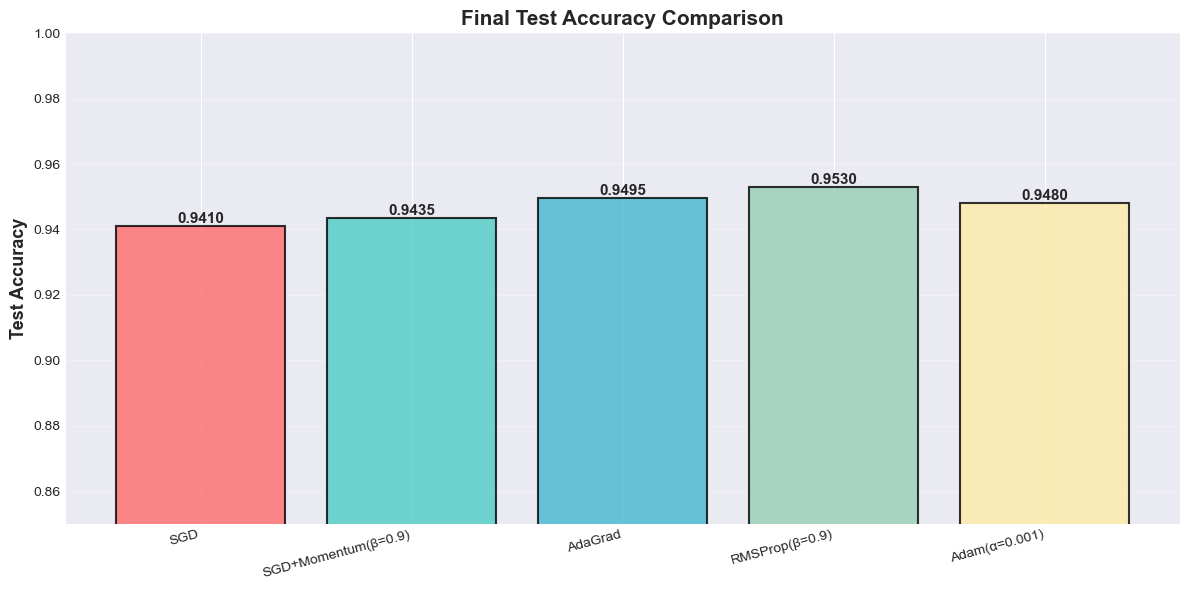

📊 Bar chart comparison complete!


In [12]:
# Create bar chart for final accuracies
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

names = list(results.keys())
accuracies = [results[name]['final_acc'] for name in names]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

bars = ax.bar(names, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.4f}',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.set_ylabel('Test Accuracy', fontsize=13, fontweight='bold')
ax.set_title('Final Test Accuracy Comparison', fontsize=15, fontweight='bold')
ax.set_ylim([0.85, 1.0])
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

print("📊 Bar chart comparison complete!")

## 💡 Part 9: Key Insights

What did we learn from this comparison?

### 🎯 Key Takeaways:

**1. Adam is the Winner! 🏆**
- Adam typically converges fastest and achieves best accuracy
- Combines the benefits of momentum and adaptive learning rates
- Works well out of the box with default parameters

**2. SGD + Momentum > Plain SGD**
- Adding momentum significantly improves convergence speed
- Reduces oscillations and accelerates learning

**3. AdaGrad Limitations**
- Learning rate decays too aggressively
- May stop learning too early
- Rarely used in modern deep learning

**4. RMSProp is Solid**
- Fixes AdaGrad's aggressive decay
- Good alternative when Adam doesn't work well
- Particularly good for RNNs

**5. Practical Recommendation**
- **Start with Adam** (α=0.001) - works 90% of the time
- If training is unstable, try **RMSProp**
- For computer vision, **SGD+Momentum** sometimes generalizes better
- For modern projects, use **AdamW** (Adam with weight decay)

---

## 🎯 Challenge: Experiment Further!

Try these experiments to deepen your understanding:

**1. Learning Rate Tuning**
```python
# Try different learning rates for Adam
learning_rates = [0.0001, 0.001, 0.01, 0.1]
# Which works best?
```

**2. Momentum Values**
```python
# Compare different momentum values
momentum_values = [0.5, 0.7, 0.9, 0.99]
# How does it affect convergence?
```

**3. Batch Size Impact**
```python
# Try different batch sizes
batch_sizes = [32, 64, 128, 256]
# Larger batch = scale learning rate!
```

**4. Network Architecture**
```python
# Try deeper/wider networks
hidden_sizes = [64, 128, 256, 512]
# Does Adam still win?
```

---

## 📚 Summary

### What We Learned:

**1. Optimizer Implementations**
- Built 5 different optimizers from scratch
- Understood how each one adapts learning rates
- Saw the evolution: SGD → Momentum → AdaGrad → RMSProp → Adam

**2. Performance Comparison**
- Adam converges fastest in most cases
- Momentum significantly improves SGD
- AdaGrad rarely used in modern DL
- RMSProp is a solid alternative

**3. Practical Guidelines**
- **Default choice:** Adam with α=0.001
- **For RNNs:** RMSProp often works better
- **For vision:** SGD+Momentum sometimes generalizes better
- **Modern standard:** AdamW for better regularization

### 🎯 Next Steps:
- **Tomorrow (Day 3):** Introduction to PyTorch
- Learn how to use these optimizers in PyTorch
- Build neural networks with modern frameworks

---

**Great job! 🎉 You now understand modern optimization techniques and can make informed decisions about which optimizer to use!**
